# Digit Classification with Keras
The goal of this notebook is to become familiar with deep neural networks and the high level Keras package. We will do so through working with one of the most classic examples of the strength of neural networks: handwritten digit classification. Parsing handwriting is a notoriously difficult task for traditional algorithms that has been made significantly easier thanks to modern deep neural networks. The following is partially adapted from a jupyter notebook developed for BU Physics professor Pankaj Mehta's course on ML for physicists (https://github.com/drckf/mlreview_notebooks/blob/master/jupyter_notebooks/notebooks/NB11_CIX-DNN_mnist_Keras.ipynb).

In this notebook we will be contructing a neural network that is capable of distinguishing between the ten handwritten digits 0-9. This is what is known in ML parlance as a *classification task*, as the model's goal is to pick a discrete label when given some input. This is distinct from a *regression task*, which is when the model's goal is to produce some analog value when given an input. Certain netowrk architectures are more suited for one task over another, so it's important to be mindful of your task throughout the entire process (more on this later).

In general, constructing a neural network to solve some data science problem is a multi-step process that roughly follows this order:

0. Set up your environment
1. Load, inspect, and process the data
2. Define the model, its architecture, and its loss function
3. Train the model
4. Evaluate the model on data it hasn't seen (validation/test data)
5. Modify the model to optimize performance (iterating 2-4)

We don't have the time to do a robust job with step 5, but we'll do a little bit to show how making structural changes to a model can affect its performance.

## Step 0: Set Up Your Environment
Before we do anything else, we need to import the packages and modules we're going to use, as well as set up parts of our environment. In particular, we'll fix our random seed so we all get the same results every time.

In [2]:
import tensorflow as tf
from tensorflow import keras as ks

import numpy as np
seed = 8
np.random.seed(seed) # fix random seed in numpy
tf.random.set_seed(seed) # fix random seed in tensorflow

import matplotlib.pyplot as plt
plt.style.use('dark_background') #Make it dark mode because we're cool
plt.rcParams.update({"figure.facecolor": "#111111",
                     "axes.facecolor": "#111111",
                     "savefig.facecolor": "#111111"})

## Step 1: Load, Inspect, and Process the Data
Keras conveniently comes with tools to download a number of datasets built in. We will be using the MNIST dataset today. The MNIST dataset comprises $70000$ handwritten digits $0-9$, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ values of the gray color, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Our intuition about the problem tells us that there are $10$ categories, so in ML jargon this is a *generic classification task with ten labels*.

To download the MNIST dataset, use the `load_data()` class from keras's `mnist` module to create the training and test data automatically. X refers to the input data (images of written digits), and Y refers to the target data (labels of each image). Once we load in the data, we want to rescale it so that instead of the hue value of each pixel being an integer in $\{0,1,\dots,255\}$, the hue value of each pixel is a decimal in $[0,1]$. In general, neural networks can experience problems if there are large variations between the minimum and maximum values of each feature, so it is considered best practice to scale data to a small interval. We also cast the labels from integer form (e.g. 5) to "one-hot" vectors (e.g. $[0,0,0,0,0,1,0,0,0,0]$), which makes it easier for the model to distinguish between classes.

Data point with label 4 :


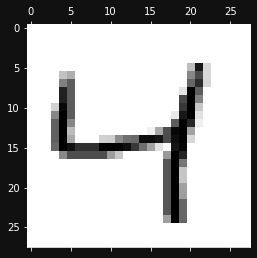

One-hot label representation: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [3]:
# Download the data, which comes pre-split between train and test datasets
(X_train, Y_train), (X_test, Y_test) = ks.datasets.mnist.load_data()

# Cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# Look at an example of data point
print('Data point with label', Y_train[2], ':')
plt.matshow(X_train[2],cmap = 'binary')
plt.show()

# Convert labels from numerical to vector (a.k.a. one-hot)
Y_train = ks.utils.to_categorical(Y_train, 10) #specify that there are ten classes!
Y_test = ks.utils.to_categorical(Y_test, 10)
print('One-hot label representation:', Y_train[20])

## Step 2: Define the Model, its Architecture, and its Loss Function
Making deep neural nets in Keras is easy thanks to Keras's `Sequential()` class, which allows the user to build deep neural networks layer by layer through a sequence of `keras.Layers` classes. Fully-connected neuron layers are known as `Dense()` layers, which accept as arguments an integer number of neurons and a type of activation function. Even more complicated layers, such as convolutional layers for 2D inputs or recurrent layers for series inputs, are all handled using this class structure. `keras.Layers` classes can also perform operations that are not strictly collections of neurons, such as the `Dropout()` layer that drops some fraction of the prior layer during training, or the `Flatten()` layer that converts its input from 2/3D to 1D. It is important to specify the input shape in the first layer and the output shape in the last layer, as otherwise we have not provided any information about what shape we expect the data to be. The input/output shapes of all the hidden layers are inferred automatically by Keras.

First, let's build the model by starting with an empty `Sequential()` class. For our first model, we'll use a simple fully-connected architecture. This architecture requires its input be one-dimensional, so the first layer will be a `Flatten()` layer with the `input_shape` argument set to `(28,28,)`, or the shape of each image in the MNIST dataset. Then we will add a 400-unit `Dense()` layer followed by a 100-unit `Dense()` layer, both with the RELU activation function (`activation = 'relu'`). Then we specify that 50% of the units in the 100-unit `Dense()` layer should be randomly dropped during training by adding a `Dropout()` layer with a droput rate of 0.5. Finally, we force the last `Dense()` layer to be in the shape of our output by specifying it to be 10 units, and give it the softmax activation function (`activation = 'softmax'`). This function produces some normalized distribution across its outputs. Depending on how we structure the loss criterion, this can easily correspond to the probability that the input corresponds to the label at each index; the argument with the maximum value is the label predicted by the model.

In [5]:
# Initiate the model
model = ks.models.Sequential()
# Flatten the input image into a 1D vector
model.add(ks.layers.Flatten(input_shape = (28,28,)))
# Add a fully-connected layer of neurons with RELU activation
model.add(ks.layers.Dense(400, activation = 'relu'))
# Add another fully-connected layer of neurons with RELU activation
model.add(ks.layers.Dense(100, activation = 'relu'))
# Apply a 50% droput rate during training
model.add(ks.layers.Dropout(0.5))
# Add a softmax layer that outputs the predicted class in the shape of the target vectors
model.add(ks.layers.Dense(10, activation = 'softmax'))

Now that we have the model's architecture defined, Keras requires that we *compile* the model by specifying its loss criterion and optimizer.

A *loss criterion* is the metric by which the model's performance is evaluated; a smaller loss must correspond to better performance. For regression tasks that most of us are used to (think linear regression), we typically use something like a mean squared error. For classification tasks the standard loss is the categorical crossentropy, a measure of how distinguisable two discrete probability distributions are from each other. Mathematically, it is given by $Loss = -y\cdot log(\hat{y})$, where $y$ is the target distribution (vector) and $\hat{y}$ is the model output distribution. The closer the two distributions are to one another, the smaller this criterion is.

The *optimizer* is simply the optimization routine used to update the parameters of each layer in the model. Here we use an adaptive optimizer called `Adam()`, which changes its gradient descent rate as it gets closer to the loss's minimum. Choosing an optimizer and its parameters is an important thing to do during hyperparameter tuning, but for simplicity's sake we're using `Adam()` in its default configuration.

At compilation, we also specify an optional metric using the `metrics` keyword, in this case `'accuracy'`. The accuracy is simply the percentage of correct predictions the model makes on the training and test sets. We specify this metric since the model's loss criterion is not in units we can intuitively understand, so this metric will help make it more obvious to us if our model is performing well or not during training in the next step.

In [6]:
#Compile the model with a loss function, optimization algorithm, and metric to be reported
model.compile(loss = ks.losses.categorical_crossentropy, optimizer = tf.optimizers.Adam(), metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 400)               314000    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               40100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 355,110
Trainable params: 355,110
Non-trainable params: 0
_________________________________________________________________


## Step 3: Train the model
As can be seen from the summary above, each of the layers we included in our model contaion some amount of tunable parameters (Column 3). Training a neural network is the process of optimizing these tuning paramters. As you can see, even the first `Dense()` layer has about five times more parameters than we have data points in the training set. This results in two things:
1. Training is slow! Even though neural networks are popular because finding the gradient over all their parameters is relatively easy, it's still computationally expensive. Finding ways to split up training into batches or picking a more well-optimized architecture are very important.
2. Training is dangerous! If you're not careful, your network can become a lookup table of your training set, which results in fantastic performance on your training set and terrible performance on your test set (overfitting). Monitoring the loss on your test set and using normalization/dropout are very important.

Training the model is syntactically very easy with Keras. The `Sequential` class has a method `fit()` that trains the model on the specified training input and target datasets. We also specify a mini-batch size (`batch-size`), length of training (`epoch`), and validation data to evaluate the model performance on to monitor for overfitting (`validation_data`).

In [7]:
#Train the model on the training data, while monitoring the performance on the test data
history = model.fit(X_train, Y_train, 
                    batch_size=64,
                    epochs=15,
                    validation_data=(X_test, Y_test))

Epoch 1/15
938/938 [==============================] - 4s 4ms/step - loss: 0.5529 - accuracy: 0.8330 - val_loss: 0.1269 - val_accuracy: 0.9610
Epoch 2/15
938/938 [==============================] - 3s 3ms/step - loss: 0.1400 - accuracy: 0.9604 - val_loss: 0.0941 - val_accuracy: 0.9706
Epoch 3/15
938/938 [==============================] - 3s 3ms/step - loss: 0.0927 - accuracy: 0.9723 - val_loss: 0.0832 - val_accuracy: 0.9752
Epoch 4/15
938/938 [==============================] - 3s 3ms/step - loss: 0.0700 - accuracy: 0.9796 - val_loss: 0.0763 - val_accuracy: 0.9776
Epoch 5/15
938/938 [==============================] - 4s 4ms/step - loss: 0.0550 - accuracy: 0.9831 - val_loss: 0.0718 - val_accuracy: 0.9798
Epoch 6/15
938/938 [==============================] - 4s 5ms/step - loss: 0.0462 - accuracy: 0.9861 - val_loss: 0.0719 - val_accuracy: 0.9797
Epoch 7/15
938/938 [==============================] - 4s 5ms/step - loss: 0.0351 - accuracy: 0.9892 - val_loss: 0.0726 - val_accuracy: 0.9799
Epoch 

## Step 4: Evaluate the Model's Performance On the Test Set
As stated before, it is important to evaluate the model's performance on the test set to have some quantitative measure of its performance, as well as to make sure it isn't overfitting. Here we evaluate using the `evaluate()` method of the `Sequential` class as well as the training history we obtained above.

313/313 [==============================] - 0s 1ms/step - loss: 0.0894 - accuracy: 0.9811

Test loss: 0.08941540122032166
Test accuracy: 0.9811000227928162


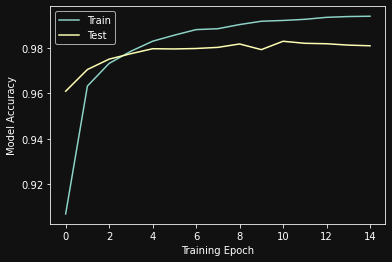

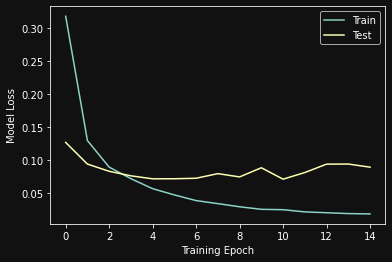

In [8]:
# Evaluate model's performance on test set
score = model.evaluate(X_test, Y_test, verbose=1)
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Summarize history of accuracy during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Model Accuracy')
plt.xlabel('Training Epoch')
plt.legend(['Train', 'Test'], loc = 'best')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Model Loss')
plt.xlabel('Training Epoch')
plt.legend(['Train', 'Test'], loc = 'best')
plt.show()

We can see from the top plot that the model identifies the digits in the test set with 98% accuracy after training. Looking at the bottom plot, we can see that the model's performance on the test set begins to get worse (higher loss) after about 5 training epochs. This means that after this point, our model has stopped learning the differences between each digit, and is instead starting to overfit and learn the noise in the dataset. In the future, training should be cut off after this point. To qualitatively understand the network's performance, it helps to look at some test cases where its predictions are incorrect. Doing so can reveal systematic problems with the model that could be solved by changing its parameters (which is exactly what we will do in the next step of this process) or dataset preparation. Below we get the predicted and actual labels for the images in the test dataset and plot one misidentified image.

Data point with label 5 :


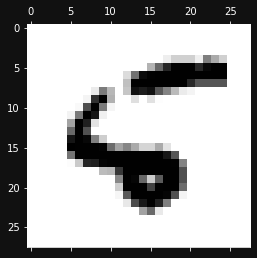

Predicted label: 6


In [9]:
predictions = np.argmax(model.predict(X_test), axis = 1) #Predicted numerical category of each element in test set
labels = np.argmax(Y_test, axis = 1) #Labeled numerical category of each element in test set
mistakes = (predictions != labels) #Boolean array of all elements in the test set that are incorrectly predicted

# Look at an example of an incorrect prediction
print('Data point with label', labels[mistakes][0], ':')
plt.matshow(X_test[mistakes][0],cmap = 'binary')
plt.show()
print('Predicted label:', predictions[mistakes][0])

It seems like most incorrectly indentified digits are due to the fact that the dataset is generated by humans with widely varying handwriting styles and cleanliness. Here we make the judgement call that we would like for the model to be able to correctly identify these digits as well, so we will not devise a way to systematically "clean" these digits out of the dataset (which seems very difficult anyhow). Instead, let's find ways to improve the model by changing its architecture.

## Step 5: Modify the Model to Optimize Performance
98% accuracy is fine, but not ideal. Some models are capable of 99.8% accurate predictions on the MNIST dataset without overfitting (https://github.com/Matuzas77/MNIST-0.17)! In order to push the boundaries of a given architecture's performance, one does not simply train the model for a longer time (as we saw above, that makes the model overfit). Instead, things like the overall shape of the model architecture, the optimization routine, the activation functions of the layers, and other *hyperparameters* of the model are modified in order to optimize the performance on the test set. This process is known as *hyperparameter tuning*.

There are many great hyperparameter tuning algortihms (I like the various flavors of KerasTuner https://keras.io/keras_tuner/ for big tasks or scikit-learn's GridSearchCV https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html for small ones), but they all rely on the same basic structure. They all broadly take some function as input that generates a compiled model given some hyperparameters as arguments. Below, we make a function that does just that (`compile_model`) that takes as input the optimizer we want to compile our model with. Then, we manually set up the parameter space we'll be searching over by specifying a bunch of possible `optimizers`. Finally, we generate and train a model that uses each optimizer while saving the results in `loss_results` in order to determine the best optimizer for the task!

Optimizer SGD
Epoch 1/5
938/938 [==============================] - 6s 6ms/step - loss: 1.4433 - accuracy: 0.5492 - val_loss: 0.4254 - val_accuracy: 0.8922
Epoch 2/5
938/938 [==============================] - 6s 7ms/step - loss: 0.5517 - accuracy: 0.8418 - val_loss: 0.3187 - val_accuracy: 0.9135
Epoch 3/5
938/938 [==============================] - 6s 6ms/step - loss: 0.4319 - accuracy: 0.8765 - val_loss: 0.2716 - val_accuracy: 0.9239
Epoch 4/5
938/938 [==============================] - 5s 6ms/step - loss: 0.3717 - accuracy: 0.8950 - val_loss: 0.2425 - val_accuracy: 0.9309
Epoch 5/5
938/938 [==============================] - 6s 6ms/step - loss: 0.3309 - accuracy: 0.9048 - val_loss: 0.2215 - val_accuracy: 0.9360
Optimizer RMSprop
Epoch 1/5
938/938 [==============================] - 9s 9ms/step - loss: 0.5049 - accuracy: 0.8487 - val_loss: 0.1295 - val_accuracy: 0.9610
Epoch 2/5
938/938 [==============================] - 9s 10ms/step - loss: 0.1378 - accuracy: 0.9617 - val_loss: 0.1061 - v

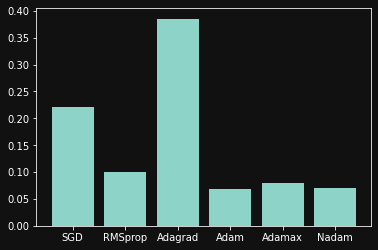

Optimal Optimizer:  Adam (loss  0.06775456666946411 )


In [10]:
#Function that automatically creates a model (could make it take arguments such as layer sizes for hyperparameter search)
def create_NN():
    # instantiate model
    model = ks.models.Sequential()
    model.add(ks.layers.Flatten(input_shape = (28,28,)))
    # Add a fully-connected layer of neurons with RELU activation
    model.add(ks.layers.Dense(400, activation = 'relu'))
    # Add another fully-connected layer of neurons with RELU activation
    model.add(ks.layers.Dense(100, activation = 'relu'))
    # Apply a 50% droput rate during training
    model.add(ks.layers.Dropout(0.5))
    # Add a softmax layer that outputs the predicted class in the shape of the target vectors
    model.add(ks.layers.Dense(10, activation = 'softmax'))
    return model

#Function that automatically compiles a model with a given optimizer (can be string or the optimizer itself)
def compile_model(optimizer=ks.optimizers.Adam()):
    # Create the model
    model = create_NN()
    # Compile the model
    model.compile(loss=ks.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

#Make the hyperparameters we'll be searching over (in this case optimizers)
optimizers = ['Adam', 'Adamax', 'Nadam']
#Stage an array to store search results
loss_results = []
#Loop over the grid, training a model at each step and storing their performance for later
for optimizer in optimizers:
    print('Optimizer', optimizer)
    model = compile_model(optimizer = optimizer)
    history = model.fit(X_train, Y_train, 
                    batch_size=64,
                    epochs=5,
                    validation_data=(X_test, Y_test))
    loss_results.append(np.min(history.history['val_loss'])) #Grab the smallest loss on the validation set during training
plt.bar(optimizers, loss_results)
plt.show()
print('Optimal Optimizer: ', optimizers[np.argmin(loss_results)], '(loss ', np.min(loss_results), ')')

As we can see above, it looks like using the NAdam can give us a small performance bump over vanilla Adam! However, it seems choosing a new optimizer wasn't enough to get our accuracy above 99%. Sometimes, the thing that needs to be changed in order to improve your model's performance isn't a parameter you're searching over. Looking at the model with a 99.83% accuracy linked above, it seems that the model architect used a Convolutional Neural Network (CNN) instead of the fully connected architecture we've been using up until this point. CNNs are well suited to two dimensional data like images, as they preserve the dimensionality of their inputs (removing the need for the `Flatten()` layer we've included in our functions so far). Let's try out a CNN!

Keras supports CNN architectures through a couple of layers, namely the `Conv2D()` and `MaxPooling2D()` layers. The exact mechanisms of each layer are outside the scope of this tutorial, but `Conv2D()` is essentially a 2D version of the `Dense()` layers we've worked with so far, and `MaxPooling2D()` shrinks the output of the `Conv2D()` layer to reduce the computational load during training. We add two of each layer together with a `Dropout()` layer, then `Flatten()` the output of the 2D layers and finish with `Dense()` layers. This model compiles and trains just like the `Sequential` models we've been using so far.

In [11]:
X_train_CNN = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test_CNN = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1,)

# instantiate model
model_CNN = ks.models.Sequential()
# add first convolutional layer with 10 filters (dimensionality of output space)
model_CNN.add(ks.layers.Conv2D(10, kernel_size = (5, 5),
                               activation = 'relu',
                               input_shape = input_shape))
# add 2D pooling layer
model_CNN.add(ks.layers.MaxPooling2D(pool_size = (2, 2)))
# add second convolutional layer with 20 filters
model_CNN.add(ks.layers.Conv2D(20, (5, 5), activation = 'relu'))
# apply dropout with rate 0.5
model_CNN.add(ks.layers.Dropout(0.5))
# add 2D pooling layer
model_CNN.add(ks.layers.MaxPooling2D(pool_size = (2, 2)))
# flatten data
model_CNN.add(ks.layers.Flatten())
# add a dense all-to-all relu layer
model_CNN.add(ks.layers.Dense(20*4*4, activation = 'relu'))
# apply dropout with rate 0.5
model_CNN.add(ks.layers.Dropout(0.5))
# soft-max layer
model_CNN.add(ks.layers.Dense(10, activation = 'softmax'))

# compile the model
model_CNN.compile(loss=ks.losses.categorical_crossentropy, optimizer = 'Adam', metrics = ['accuracy'])

# train CNN
model_CNN.fit(X_train_CNN, Y_train, 
              batch_size = 64, 
              epochs = 10,
              validation_data = (X_test_CNN, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test_CNN, Y_test, verbose = 1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
938/938 [==============================] - 27s 28ms/step - loss: 0.5446 - accuracy: 0.8235 - val_loss: 0.0860 - val_accuracy: 0.9803
Epoch 2/10
938/938 [==============================] - 25s 27ms/step - loss: 0.1130 - accuracy: 0.9657 - val_loss: 0.0705 - val_accuracy: 0.9828
Epoch 3/10
938/938 [==============================] - 23s 25ms/step - loss: 0.0854 - accuracy: 0.9736 - val_loss: 0.0482 - val_accuracy: 0.9883
Epoch 4/10
938/938 [==============================] - 24s 26ms/step - loss: 0.0684 - accuracy: 0.9783 - val_loss: 0.0367 - val_accuracy: 0.9911
Epoch 5/10
938/938 [==============================] - 24s 25ms/step - loss: 0.0601 - accuracy: 0.9806 - val_loss: 0.0376 - val_accuracy: 0.9899
Epoch 6/10
938/938 [==============================] - 23s 25ms/step - loss: 0.0518 - accuracy: 0.9842 - val_loss: 0.0358 - val_accuracy: 0.9910
Epoch 7/10
938/938 [==============================] - 23s 25ms/step - loss: 0.0478 - accuracy: 0.9859 - val_loss: 0.0391 - val_accuracy:

And would you look at that, a >99% accuracy rate! Seems like what we really needed to do was use a more suitable architecture for the problem. 